In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
import torch, numpy as np
from minai.core import *
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [ ]:
set_seed(42)

## Prepare

In [ ]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=0,
    use_flash_attention_2=True,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
dataset = load_dataset("knowrohit07/know_sql", revision='f33425d13f9e8aab1b46fa945326e9356d6d5726', split="train")

In [ ]:
def to_text(x):
    x['text'] = 'Context: ' + x['context'] + '\nQuestion: ' + x['question'] + '\nAnswer: ' + x['answer']
    # tokenize here?
    return x

def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [ ]:
lf = nn.CrossEntropyLoss()

This dataset is for training a model to generate SQL.

In the dataset, every item presents as context the schema defining a table and an English question to translate into a SELECT query. The answer is the appropriate SELECT query.

In [ ]:
next(iter(dataset))

{'question': "Which head's name has the substring 'Ha'? List the id and name.",
 'context': 'CREATE TABLE head (head_id VARCHAR, name VARCHAR)',
 'answer': "SELECT head_id, name FROM head WHERE name LIKE '%Ha%'"}

We now preprocess to create a single field `text`, collecting this information into a single string formatted of Context, Question, Answer.

In [ ]:
to_text(next(iter(dataset)))

{'question': "Which head's name has the substring 'Ha'? List the id and name.",
 'context': 'CREATE TABLE head (head_id VARCHAR, name VARCHAR)',
 'answer': "SELECT head_id, name FROM head WHERE name LIKE '%Ha%'",
 'text': "Context: CREATE TABLE head (head_id VARCHAR, name VARCHAR)\nQuestion: Which head's name has the substring 'Ha'? List the id and name.\nAnswer: SELECT head_id, name FROM head WHERE name LIKE '%Ha%'"}

We shuffle, filter to only small items, and split into train/eval sets.

(It is not strictly necessary to shuffle now, since the DataLoader will shuffle the train set for us later.)

In [ ]:
dataset = dataset.shuffle(42).map(to_text).filter(lambda x:len(x['text'])<380)

In [ ]:
train_dataset = dataset.select(range(0, len(dataset)-200)) # Subset for testing
eval_dataset = dataset.select(range(len(dataset)-200, len(dataset))) # And only 200 eval samples
train_dataset

Dataset({
    features: ['question', 'context', 'answer', 'text'],
    num_rows: 76119
})

In [ ]:
# Reorder by length

In [ ]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [ ]:
batch_size = 64

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

In [ ]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [ ]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([64, 115]), torch.Size([64, 115]))

Note that the first size dimension above was the batch_size we set, 64.

But the second size dimension is likely to be _less_ than the max permitted sequence length we filtered to, of 280. Why? Because the dimensions of a batch will be determined by the maxi existing sequence length _in that batch_.

Because we have set `shuffle=True`, you will get a different initial batch with different max seq length, and therefore different dimensions, every time you re-evaluate the above cell.

In [ ]:
tokenizer.decode(xb[0])[:250]

'<s> Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></'

In [ ]:
tokenizer.decode(yb[0])[:250]

'Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></s></'

Two points to note:

- the tokenizer introduced a `<s>` beginning-of-sequence token, to help the model recognize the beginning of the input sequence, in the input `xb[0]`.
- the label `yb[0]` is equal to `xb[0]`, except by not having the beginning of sequence token, by having one more token at the end. That last token is the next token to predict.


## Training

In [ ]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [ ]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [ ]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# m = get_peft_model(m, peft_config)

In [ ]:
from torch import optim

In [ ]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), MetricsCB()]

In [ ]:
# Just freeze embeddings for small memory decrease
m.model.embed_tokens.weight.requires_grad_(False);

`requires_grad == False` tells PyTorch not to track gradient values. Gradient values are used to update weights in training. So setting requires_grad to False turns off training of those weights, the weights used to define initial embedding layer which maps a token value to an embedding vector. Training fewer weights requires less memory.

But why can turn off _these_ weights? Embedding layers are relatively expensive in terms of parameter count.

But why can we get away with it? Empirically, it turns out (✨) that freezing them often has only a minimal impact on downstream task performance.

In [ ]:
len(m.model.layers)

32

In [ ]:
# Or freeze first n layers for larger decrease (in this case, 24). (Can freeze up to len(m.model.layers)-1)
n_freeze = 24
for param in m.parameters(): param.requires_grad = False
for param in m.lm_head.parameters(): param.requires_grad = True
for param in m.model.layers[n_freeze:].parameters(): param.requires_grad = True

In [ ]:
from functools import partial
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [ ]:
lr = 1e-3
sz = len(dls.train)//50

`epoch_sz` controls how many batches are seen before validation metrics are reported. It lets us define a pseudo "epoch" which is smaller than a true epoch

In [ ]:
cb_trn = TrainCB(preds_nm='logits')
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)
# learn = TrainLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz)
# learn = Learner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[cb_trn], epoch_sz=sz) #, opt_func=optim)

In [ ]:
m.gradient_checkpointing_enable()

In [ ]:
# NB lr_find does *not* reset model, so recreate it afterwards
# learn.lr_find(max_mult=10)

Train for 1 "epoch"

loss,epoch,train
2.084,0,train
1.052,0,eval


/home/algal/miniconda3/envs/mbert/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


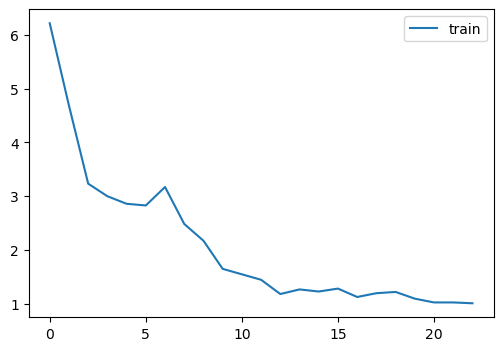

In [ ]:
learn.fit(1, cbs=prog)

In [ ]:
# learn.model.save_pretrained('models/sql_1ep_636')

In [ ]:
#SGD
torch.cuda.max_memory_allocated()/1_000_000_000

16.106410496

In [ ]:
#adam
torch.cuda.max_memory_allocated()/1_000_000_000

16.106410496

## Testing

In [ ]:
prompt = "Context:" + eval_dataset[0]['context'] + "\nQuestion:" + eval_dataset[0]['question'] + "\nAnswer:"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()

In [ ]:
with torch.inference_mode():
    output = m.generate(tokenized_prompt, max_new_tokens=90)

In [ ]:
print(prompt + tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True))

Context:CREATE TABLE table_name_95 (tournament VARCHAR, score VARCHAR, outcome VARCHAR, surface VARCHAR)
Question:Which tournament has an Outcome of runner-up, a Surface of hard, and a Score of 6–4, 6–2?
Answer:Answer:


To produce better inference results, it would be better to use an instruct model and to ensure the dataset is in the format expected by the model.

## fin -